<br>



<br>
<center><font size='10' style="color:cadetblue"><b> Customer Transaction Prediction </b> </font>




<br>
<center><font size='5' style="color:darkgray"><b> Proyecto Final - Coder House </b> </font>

<br>
<br>

<center><font size='5' style="color:darkgray"><b> Notebook Zarina Madelaine Breitman </b> </font>
    
<br>
<br>
    
<center><font size='5' style="color:darkgray"><b> Notebook II  de II </b> </font> 

<br>
<br>
<br>

<font size='6' style="color:cadetblue"><b> Content </b> </font>
<a name="content"></a>
<br>


1. [Imports](#Imports) 
<br>
<br>

2. [Dataset](#Dataset) 
<br>
<br>

3. [Model testing: LightGBM](#LightGBM)
<br>
<br>

4. [Principal components analysis](#PCA)
<br>

    4.1 [LightGBM 175 componentes](#175)
    
    4.2 [LightGBM 150 componentes](#150)

    4.3 [LightGBM 125 componentes](#125)

    4.4 [LightGBM 100 componentes](#100)
    
    4.5 [Resumen de modelos](#Summary)
    <br>
    
    
5. [Optimización Bayesiana con Optuna](#Optuna)
<br>

    5.1 [Optimización de LightGBM PCA 175](#Optimizacion175)
    
    5.2 [Optimización de LightGBM PCA 100](#Optimizacion100)
    
    5.3 [LightGBM optimizado](#Optimizado)
    <br>
    
    
6. [Resumen de todos los modelos y conclusión](#Resumen_final)

<br>
<br>
<br>
<br>

<font size='6' style="color:cadetblue"><b> Imports </b> </font>
<a name="Imports"></a>
<br>

Las importaciones realizadas están divididas según el rol que tienen en la notebook. 

In [79]:
# Numeric, scientific and data science libraries
# -------------------------------------------------------------------------------------------
import pandas as pd
import numpy as np


# Visualization
# -------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn imports
# -------------------------------------------------------------------------------------------

# Data preparation for training
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA

# Models from Sklearn
from lightgbm import LGBMClassifier

#Metrics 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from scipy.stats import gmean



# Bayesian Optimization
# -------------------------------------------------------------------------------------------
import optuna


# Other imports
import time
import pickle
import joblib

<br>
<br>
<br>
<br>

<font size='6' style="color:cadetblue"><b> Dataset </b> </font>

<a name="Dataset"></a>

[[ Back to Top ]](#content)

In [36]:
# Readind the dataset

df = pd.read_pickle("trainDownCast.pkl")
df.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
ID_code,,,,,,,,,,,,,,,,,,,,,
train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.522699,-2.3978,7.8784,8.5635,12.780300,-1.0914
train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.430500,2.0339,8.1267,8.7889,18.356001,1.9518
train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,2.9057,9.7905,1.6704,1.6858,21.604200,3.1417,-6.5213,8.2675,14.722200,0.3965
train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.4666,4.7433,0.7178,1.4214,23.034700,-1.2706,-2.9275,10.2922,17.969700,-8.9996
train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,13.287600,-1.5121,3.9267,9.5031,17.997400,-8.8104


<br>

In [37]:
#Dividimos el set de datos en datos a predecir (y) y los datos utilizados para alcanzar esas predicciones (X) 

X= df.drop(columns= ['target'])
y= df['target']

In [38]:
#Con un dataset tan asimétrico, reducimos el posible error separando los datos empleando Stratified KFold
#Utilizamos 10 folds para manteneres la misma proporción de variables/target que en el dataset original 

skf = StratifiedKFold(n_splits=10, shuffle= True, random_state= 1)
skf.get_n_splits(X, y)

10

In [47]:
#create a list to store all metrics results

metrics = []
models = []
tiempo = []

<br>
<br>
<br>
<br>

<font size='6' style="color:cadetblue"><b> LightGBM </b> </font>

<a name="LightGBM"></a>

[[ Back to Top ]](#content)

Dado que LightGBM es un modelo de boosting mucho más liviano y veloz que otros como XGBoost o Catboost se eligió evaluar el rendimiento de este modelo y optimizar sus parámetros a través de la Optimización Bayesiana para luego implementar estos parámetros en modelos de boosting más complejos.

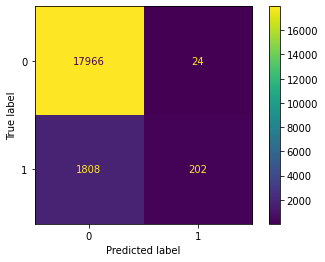

Precision's geometric mean is  0.8731491174118706
Recall's geometric mean is  0.09469890274129372
F1 geometric mean is  0.170857624360795
El tiempo del modelo fue de  110.11068391799927 segundos


In [48]:
#Calling the model
lgbm = LGBMClassifier()

#lista para almacenar las métricas de cada fold
model_metrics=[]

#inicio el contador de tiempo para calcular el costo del modelo
inicio = time.time()

#Split between training and testing
for train_index, test_index in skf.split(X, y):
        
    X_train=X.iloc[train_index]
    X_test=X.iloc[test_index]
    y_train=y.iloc[train_index]
    y_test=y.iloc[test_index]
    #fit the model
    lgbm.fit(X_train, y_train)
    
    #make predictions
    y_pred=lgbm.predict(X_test)
    
    #calculate metrics
    cm=confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1= f1_score(y_test, y_pred)

    #store each fold's metrics
    results = [precision, recall, f1]
    model_metrics.append(results)
    
#display the first fold's confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()
plt.show()

#finalizamos el contador de tiempo del modelo
fin = time.time()

#store and print the metric's gmean after the 10 folds
results_gmean= gmean(model_metrics)
print("Precision's geometric mean is " , results_gmean[0])
print("Recall's geometric mean is ", results_gmean[1])
print("F1 geometric mean is ", results_gmean[2])

#add these to the general lists
models.append("Light GBM")
metrics.append(results_gmean)
tiempo.append(fin-inicio)

print("El tiempo del modelo fue de ", fin-inicio, "segundos")

<br>
<br>
<br>
<br>


<font size='6' style="color:cadetblue"><b> PCA </b> </font>

<a name="PCA"></a>

[[ Back to Top ]](#content)

In [49]:
#In order to work with Optuna, a smaller dataset will be created using PCA method

# Armamos varios PCA para probar con distinto númro de componentes
#PCA100
pca100 = PCA(n_components=100)

#PCA125
pca125 = PCA(n_components=125)

#PCA150
pca150 = PCA(n_components=150)

#PCA175
pca175 = PCA(n_components=175)

<br>
<br>
<br>
<br>

<font size='4' style="color:darkorchid"><b> LightGBM with PCA 175 components </b> </font>

<a name="175"></a>

[[ Back to Top ]](#content)

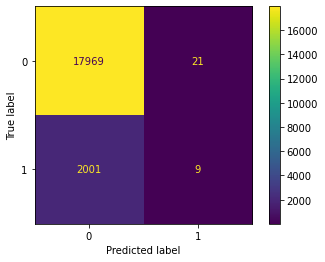

Precision's geometric mean is  0.2750311663852587
Recall's geometric mean is  0.005777977299016975
F1 geometric mean is  0.011315060041070775
El tiempo del modelo fue de  106.98619532585144 segundos


In [50]:
#creamos el modelo
lgbm175 = LGBMClassifier()

#creamos una lista para almacenar las métricas de los 10 folds
model_metrics=[]

#inicio el contador de tiempo para calcular el costo del modelo
inicio = time.time()

#Split entre training y testing
for train_index, test_index in skf.split(X, y):
        
    X_train=pca175.fit_transform(X.iloc[train_index])
    X_test=pca175.fit_transform(X.iloc[test_index])
    y_train=y.iloc[train_index]
    y_test=y.iloc[test_index]
    
    #fit the model
    lgbm175.fit(X_train, y_train)
    
    #make predictions
    y_pred=lgbm175.predict(X_test)
    
    #calculate metrics
    cm=confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1= f1_score(y_test, y_pred)

    #store each fold's metrics
    results = [precision, recall, f1]
    model_metrics.append(results)
    
#display the first fold's confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()
plt.show()

#finalizamos el contador de tiempo del modelo
fin = time.time()

#store and print the metric's gmean after the 10 folds
results_gmean= gmean(model_metrics)
print("Precision's geometric mean is " , results_gmean[0])
print("Recall's geometric mean is ", results_gmean[1])
print("F1 geometric mean is ", results_gmean[2])

#add these to the general lists
models.append("Light GBM 175")
metrics.append(results_gmean)
tiempo.append(fin-inicio)

print("El tiempo del modelo fue de ", fin-inicio, "segundos")


In [72]:
# Save the model
# ==============================================================================
pkl_path = "LightBoostPCA175.pkl"

with open(pkl_path, "wb") as f:
    # Pickle the 'lgbm100' model using the highest protocol available.
    pickle.dump(lgbm175, f)

<br>
<br>
<br>
<br>

<font size='4' style="color:darkorchid"><b> LightGBM with PCA 150 components </b> </font>

<a name="150"></a>

[[ Back to Top ]](#content)

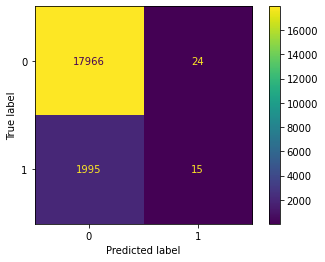

Precision's geometric mean is  0.31067403963116597
Recall's geometric mean is  0.0074743112645649186
F1 geometric mean is  0.014590894078075607
El tiempo del modelo fue de  146.930326461792 segundos


In [52]:
#creamos el modelo
lgbm150 = LGBMClassifier()

#lista para almacenar las métricas de cada fold
model_metrics=[]

#inicio el contador de tiempo para calcular el costo del modelo
inicio = time.time()

#Split between training and testing
for train_index, test_index in skf.split(X, y):
        
    X_train=pca150.fit_transform(X.iloc[train_index])
    X_test=pca150.fit_transform(X.iloc[test_index])
    y_train=y.iloc[train_index]
    y_test=y.iloc[test_index]
    #fit the model
    lgbm150.fit(X_train, y_train)
    
    #make predictions
    y_pred=lgbm150.predict(X_test)
    
    #calculate metrics
    cm=confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1= f1_score(y_test, y_pred)

    #store each fold's metrics
    results = [precision, recall, f1]
    model_metrics.append(results)
    
#display the first fold's confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()
plt.show()

#finalizamos el contador de tiempo del modelo
fin = time.time()

#store and print the metric's gmean after the 10 folds
results_gmean= gmean(model_metrics)
print("Precision's geometric mean is " , results_gmean[0])
print("Recall's geometric mean is ", results_gmean[1])
print("F1 geometric mean is ", results_gmean[2])

#add these to the general lists
models.append("Light GBM 150")
metrics.append(results_gmean)
tiempo.append(fin-inicio)

print("El tiempo del modelo fue de ", fin-inicio, "segundos")

In [71]:
# Save the model
# ==============================================================================
pkl_path = "LightBoostPCA150.pkl"

with open(pkl_path, "wb") as f:
    # Pickle the 'lgbm150' model using the highest protocol available.
    pickle.dump(lgbm150, f)

<br>
<br>
<br>
<br>

<font size='4' style="color:darkorchid"><b> LightGBM with PCA 125 components </b> </font>

<a name="125"></a>

[[ Back to Top ]](#content)

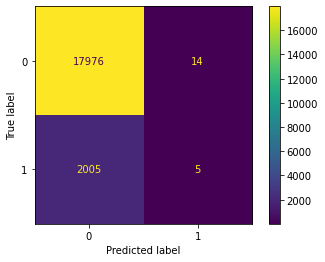

Precision's geometric mean is  0.229340138416644
Recall's geometric mean is  0.0038239382767338076
F1 geometric mean is  0.007518868841883683
El tiempo del modelo fue de  129.09689950942993 segundos


In [54]:
#creamos el modelo
lgbm125 = LGBMClassifier()

#lista para almacenar las métricas de cada fold
model_metrics=[]

#inicio el contador de tiempo para calcular el costo del modelo
inicio = time.time()

#Split between training and testing
for train_index, test_index in skf.split(X, y):
        
    X_train=pca125.fit_transform(X.iloc[train_index])
    X_test=pca125.fit_transform(X.iloc[test_index])
    y_train=y.iloc[train_index]
    y_test=y.iloc[test_index]
    #fit the model
    lgbm125.fit(X_train, y_train)
    
    #make predictions
    y_pred=lgbm125.predict(X_test)
    
    #calculate metrics
    cm=confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1= f1_score(y_test, y_pred)

    #store each fold's metrics
    results = [precision, recall, f1]
    model_metrics.append(results)
    
#display the first fold's confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()
plt.show()

#finalizamos el contador de tiempo del modelo
fin = time.time()

#store and print the metric's gmean after the 10 folds
results_gmean= gmean(model_metrics)
print("Precision's geometric mean is " , results_gmean[0])
print("Recall's geometric mean is ", results_gmean[1])
print("F1 geometric mean is ", results_gmean[2])

#add these to the general lists
models.append("Light GBM 125")
metrics.append(results_gmean)
tiempo.append(fin-inicio)

print("El tiempo del modelo fue de ", fin-inicio, "segundos")

In [70]:
# Save the model
# ==============================================================================
pkl_path = "LightBoostPCA125.pkl"

with open(pkl_path, "wb") as f:
    # Pickle the 'lgbm125' model using the highest protocol available.
    pickle.dump(lgbm125, f)

<br>
<br>
<br>
<br>

<font size='4' style="color:darkorchid"><b> LightGBM with PCA 100 components </b> </font>

<a name="100"></a>

[[ Back to Top ]](#content)

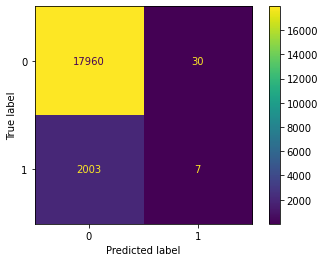

Precision's geometric mean is  0.2369741334119722
Recall's geometric mean is  0.0043159318880780706
F1 geometric mean is  0.008477076263159434
El tiempo del modelo fue de  119.71798896789551 segundos


In [56]:
#creamos el modelo
lgbm100 = LGBMClassifier()

#lista para almacenar las métricas de cada fold
model_metrics=[]

#inicio el contador de tiempo para calcular el costo del modelo
inicio = time.time()

#Split between training and testing
for train_index, test_index in skf.split(X, y):
        
    X_train=pca100.fit_transform(X.iloc[train_index])
    X_test=pca100.fit_transform(X.iloc[test_index])
    y_train=y.iloc[train_index]
    y_test=y.iloc[test_index]
    #fit the model
    lgbm100.fit(X_train, y_train)
    
    #make predictions
    y_pred=lgbm100.predict(X_test)
    
    #calculate metrics
    cm=confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1= f1_score(y_test, y_pred)

    #store each fold's metrics
    results = [precision, recall, f1]
    model_metrics.append(results)
    
#display the first fold's confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()
plt.show()

#finalizamos el contador de tiempo del modelo
fin = time.time()

#store and print the metric's gmean after the 10 folds
results_gmean= gmean(model_metrics)
print("Precision's geometric mean is " , results_gmean[0])
print("Recall's geometric mean is ", results_gmean[1])
print("F1 geometric mean is ", results_gmean[2])

#add these to the general lists
models.append("Light GBM 100")
metrics.append(results_gmean)
tiempo.append(fin-inicio)

print("El tiempo del modelo fue de ", fin-inicio, "segundos")

In [69]:
# Save the model
# ==============================================================================
pkl_path = "LightBoostPCA100.pkl"

with open(pkl_path, "wb") as f:
    # Pickle the 'lgbm100' model using the highest protocol available.
    pickle.dump(lgbm100, f)

<br>
<br>
<br>
<br>

<font size='4' style="color:darkorchid"><b> Resumen de modelos </b> </font>

<a name="Summary"></a>

[[ Back to Top ]](#content)

In [57]:
metrics

[array([0.87314912, 0.0946989 , 0.17085762]),
 array([0.27503117, 0.00577798, 0.01131506]),
 array([0.31067404, 0.00747431, 0.01459089]),
 array([0.22934014, 0.00382394, 0.00751887]),
 array([0.23697413, 0.00431593, 0.00847708])]

In [59]:
columnas = ["PRECISION", "RECALL", "F1"]
resumen = pd.DataFrame(metrics, columns=columnas, index=models)
resumen

,PRECISION,RECALL,F1
Light GBM,0.873149,0.094699,0.170858
Light GBM 175,0.275031,0.005778,0.011315
Light GBM 150,0.310674,0.007474,0.014591
Light GBM 125,0.229340,0.003824,0.007519
Light GBM 100,0.236974,0.004316,0.008477


In [60]:
resumen['TIEMPO (s)'] = tiempo
resumen

,PRECISION,RECALL,F1,TIEMPO (s)
Light GBM,0.873149,0.094699,0.170858,110.110684
Light GBM 175,0.275031,0.005778,0.011315,106.986195
Light GBM 150,0.310674,0.007474,0.014591,146.930326
Light GBM 125,0.229340,0.003824,0.007519,129.096900
Light GBM 100,0.236974,0.004316,0.008477,119.717989


In [ ]:
resumen.to_pickle('df_resumen_LGBM.pkl')

<br>
<br>
<br>
<br>

<font size='6' style="color:cadetblue"><b> Optimización Bayesiana con Optuna </b> </font>

<a name="Optuna"></a>

[[ Back to Top ]](#content)

En vista de las métricas obtenidas en la tabla de resultadosm donde el modelo LightGBM con un pca de 175 componente fue el modelo que menos tiempo tomó y el segundo mejor en Recall, se lo eligió para realizar la optimización Bayesiana. 

<br>
<br>

<font size='4' style="color:darkorchid"><b> Optimización de LightGBM PCA 175  </b> </font>

<a name="Optimizacion175"></a>

[[ Back to Top ]](#content)

In [87]:
recall_results175 = [] 

# Objective function for the Light GBM Model
# ==============================================================================
def objective_lgbm175(trial):
    # hyperparameter setting
    lgbm175__max_depth = trial.suggest_int ('lgbm1175__max_depth', 3, 21)
    lgbm175__n_estimators = trial.suggest_int('lgbm175__n_estimators', 300, 3000, 10)

    
    #splitting th dataset
    for train_index, test_index in skf.split(X,y):
        X_train=pca175.fit_transform(X.iloc[train_index])
        X_test=pca175.transform(X.iloc[test_index])
        y_train=y.iloc[train_index]
        y_test=y.iloc[test_index]
        
             
    
    #model training
    model = LGBMClassifier(max_depth= lgbm175__max_depth, n_estimators= lgbm175__n_estimators) 
    model.fit(X_train, y_train)
    
    #predictions
    y_pred = model.predict(X_test)
    
    
    #evaluation metrics
    recall = recall_score(y_test, y_pred)
    recall_results.append(recall)
    
    return gmean(recall_results)

In [88]:
study_lgbm175 = optuna.create_study(direction= 'maximize')

study_lgbm175.optimize(objective_lgbm175, n_trials= 300)

[I 2022-11-21 13:08:08,718] A new study created in memory with name: no-name-fc3d07e0-3d93-42af-bb29-0ad048b2cc48
[I 2022-11-21 13:09:51,154] Trial 0 finished with value: 0.12959990214712075 and parameters: {'lgbm1175__max_depth': 11, 'lgbm175__n_estimators': 1910}. Best is trial 0 with value: 0.12959990214712075.
[I 2022-11-21 13:11:02,051] Trial 1 finished with value: 0.12993863367559547 and parameters: {'lgbm1175__max_depth': 4, 'lgbm175__n_estimators': 1620}. Best is trial 1 with value: 0.12993863367559547.
[I 2022-11-21 13:12:58,585] Trial 2 finished with value: 0.13017024048779113 and parameters: {'lgbm1175__max_depth': 7, 'lgbm175__n_estimators': 2430}. Best is trial 2 with value: 0.13017024048779113.
[I 2022-11-21 13:13:32,106] Trial 3 finished with value: 0.13007408551872232 and parameters: {'lgbm1175__max_depth': 3, 'lgbm175__n_estimators': 320}. Best is trial 2 with value: 0.13017024048779113.
[I 2022-11-21 13:14:19,093] Trial 4 finished with value: 0.13031987963639438 and p

[I 2022-11-21 13:57:35,422] Trial 38 finished with value: 0.13801305067725192 and parameters: {'lgbm1175__max_depth': 8, 'lgbm175__n_estimators': 1030}. Best is trial 38 with value: 0.13801305067725192.
[I 2022-11-21 13:59:04,305] Trial 39 finished with value: 0.13822982508603712 and parameters: {'lgbm1175__max_depth': 7, 'lgbm175__n_estimators': 1790}. Best is trial 39 with value: 0.13822982508603712.
[I 2022-11-21 14:00:40,599] Trial 40 finished with value: 0.13843786622238322 and parameters: {'lgbm1175__max_depth': 8, 'lgbm175__n_estimators': 2020}. Best is trial 40 with value: 0.13843786622238322.
[I 2022-11-21 14:02:11,830] Trial 41 finished with value: 0.138650209778793 and parameters: {'lgbm1175__max_depth': 8, 'lgbm175__n_estimators': 1850}. Best is trial 41 with value: 0.138650209778793.
[I 2022-11-21 14:03:43,284] Trial 42 finished with value: 0.13886163804034382 and parameters: {'lgbm1175__max_depth': 8, 'lgbm175__n_estimators': 1850}. Best is trial 42 with value: 0.13886163

[I 2022-11-21 15:12:29,401] Trial 76 finished with value: 0.144849264471775 and parameters: {'lgbm1175__max_depth': 19, 'lgbm175__n_estimators': 3000}. Best is trial 76 with value: 0.144849264471775.
[I 2022-11-21 15:14:31,418] Trial 77 finished with value: 0.1450049671055794 and parameters: {'lgbm1175__max_depth': 20, 'lgbm175__n_estimators': 2600}. Best is trial 77 with value: 0.1450049671055794.
[I 2022-11-21 15:16:33,723] Trial 78 finished with value: 0.1451600141360273 and parameters: {'lgbm1175__max_depth': 20, 'lgbm175__n_estimators': 2620}. Best is trial 78 with value: 0.1451600141360273.
[I 2022-11-21 15:18:34,382] Trial 79 finished with value: 0.14531177536340537 and parameters: {'lgbm1175__max_depth': 20, 'lgbm175__n_estimators': 2580}. Best is trial 79 with value: 0.14531177536340537.
[I 2022-11-21 15:20:29,906] Trial 80 finished with value: 0.14546289735914023 and parameters: {'lgbm1175__max_depth': 20, 'lgbm175__n_estimators': 2470}. Best is trial 80 with value: 0.1454628

[I 2022-11-21 16:25:39,389] Trial 114 finished with value: 0.15060894338514647 and parameters: {'lgbm1175__max_depth': 18, 'lgbm175__n_estimators': 2100}. Best is trial 114 with value: 0.15060894338514647.
[I 2022-11-21 16:27:25,780] Trial 115 finished with value: 0.1507597105720729 and parameters: {'lgbm1175__max_depth': 18, 'lgbm175__n_estimators': 2090}. Best is trial 115 with value: 0.1507597105720729.
[I 2022-11-21 16:29:09,486] Trial 116 finished with value: 0.15091226214033618 and parameters: {'lgbm1175__max_depth': 18, 'lgbm175__n_estimators': 2040}. Best is trial 116 with value: 0.15091226214033618.
[I 2022-11-21 16:30:53,337] Trial 117 finished with value: 0.1510642370551516 and parameters: {'lgbm1175__max_depth': 18, 'lgbm175__n_estimators': 2040}. Best is trial 117 with value: 0.1510642370551516.
[I 2022-11-21 16:32:34,431] Trial 118 finished with value: 0.15121328739609557 and parameters: {'lgbm1175__max_depth': 18, 'lgbm175__n_estimators': 1950}. Best is trial 118 with va

[I 2022-11-21 17:27:59,907] Trial 152 finished with value: 0.15603579352158256 and parameters: {'lgbm1175__max_depth': 16, 'lgbm175__n_estimators': 1550}. Best is trial 152 with value: 0.15603579352158256.
[I 2022-11-21 17:30:10,109] Trial 153 finished with value: 0.15617046320192127 and parameters: {'lgbm1175__max_depth': 16, 'lgbm175__n_estimators': 1530}. Best is trial 153 with value: 0.15617046320192127.
[I 2022-11-21 17:31:50,203] Trial 154 finished with value: 0.15630168214392387 and parameters: {'lgbm1175__max_depth': 16, 'lgbm175__n_estimators': 1550}. Best is trial 154 with value: 0.15630168214392387.
[I 2022-11-21 17:33:24,878] Trial 155 finished with value: 0.15643243509377397 and parameters: {'lgbm1175__max_depth': 16, 'lgbm175__n_estimators': 1550}. Best is trial 155 with value: 0.15643243509377397.
[I 2022-11-21 17:34:55,200] Trial 156 finished with value: 0.15656272448388828 and parameters: {'lgbm1175__max_depth': 16, 'lgbm175__n_estimators': 1560}. Best is trial 156 wit

[I 2022-11-21 18:25:00,444] Trial 190 finished with value: 0.1613392511140217 and parameters: {'lgbm1175__max_depth': 13, 'lgbm175__n_estimators': 1170}. Best is trial 190 with value: 0.1613392511140217.
[I 2022-11-21 18:26:17,218] Trial 191 finished with value: 0.16147666608429412 and parameters: {'lgbm1175__max_depth': 13, 'lgbm175__n_estimators': 1180}. Best is trial 191 with value: 0.16147666608429412.
[I 2022-11-21 18:27:30,861] Trial 192 finished with value: 0.16161496711756318 and parameters: {'lgbm1175__max_depth': 13, 'lgbm175__n_estimators': 1150}. Best is trial 192 with value: 0.16161496711756318.
[I 2022-11-21 18:28:45,638] Trial 193 finished with value: 0.16175282596075263 and parameters: {'lgbm1175__max_depth': 13, 'lgbm175__n_estimators': 1150}. Best is trial 193 with value: 0.16175282596075263.
[I 2022-11-21 18:29:59,931] Trial 194 finished with value: 0.1618915634425153 and parameters: {'lgbm1175__max_depth': 13, 'lgbm175__n_estimators': 1140}. Best is trial 194 with v

[I 2022-11-21 19:10:47,449] Trial 228 finished with value: 0.16598857681072046 and parameters: {'lgbm1175__max_depth': 11, 'lgbm175__n_estimators': 1030}. Best is trial 228 with value: 0.16598857681072046.
[I 2022-11-21 19:12:04,578] Trial 229 finished with value: 0.16610187820709818 and parameters: {'lgbm1175__max_depth': 11, 'lgbm175__n_estimators': 1030}. Best is trial 229 with value: 0.16610187820709818.
[I 2022-11-21 19:13:11,680] Trial 230 finished with value: 0.1662161340241533 and parameters: {'lgbm1175__max_depth': 11, 'lgbm175__n_estimators': 900}. Best is trial 230 with value: 0.1662161340241533.
[I 2022-11-21 19:14:19,623] Trial 231 finished with value: 0.16632413313224897 and parameters: {'lgbm1175__max_depth': 11, 'lgbm175__n_estimators': 870}. Best is trial 231 with value: 0.16632413313224897.
[I 2022-11-21 19:15:25,766] Trial 232 finished with value: 0.1664363937255315 and parameters: {'lgbm1175__max_depth': 11, 'lgbm175__n_estimators': 890}. Best is trial 232 with valu

[I 2022-11-21 19:51:42,974] Trial 266 finished with value: 0.17008434814100984 and parameters: {'lgbm1175__max_depth': 9, 'lgbm175__n_estimators': 770}. Best is trial 266 with value: 0.17008434814100984.
[I 2022-11-21 19:52:45,581] Trial 267 finished with value: 0.17018222813137612 and parameters: {'lgbm1175__max_depth': 9, 'lgbm175__n_estimators': 770}. Best is trial 267 with value: 0.17018222813137612.
[I 2022-11-21 19:53:45,403] Trial 268 finished with value: 0.17027792004171916 and parameters: {'lgbm1175__max_depth': 8, 'lgbm175__n_estimators': 750}. Best is trial 268 with value: 0.17027792004171916.
[I 2022-11-21 19:54:50,446] Trial 269 finished with value: 0.17037332971476213 and parameters: {'lgbm1175__max_depth': 8, 'lgbm175__n_estimators': 750}. Best is trial 269 with value: 0.17037332971476213.
[I 2022-11-21 19:55:53,348] Trial 270 finished with value: 0.17046845838242541 and parameters: {'lgbm1175__max_depth': 8, 'lgbm175__n_estimators': 750}. Best is trial 270 with value: 0

In [89]:
print('Best Value: {}'.format(study_lgbm175.best_value))
print('Best Parameters: {}'.format(study_lgbm175.best_params))

Best Value: 0.1734435020448431
Best Parameters: {'lgbm1175__max_depth': 7, 'lgbm175__n_estimators': 510}


In [90]:
joblib.dump(study_lgbm175, "study_lgbm175.pkl")

['study_lgbm175.pkl']

C:\Users\Madelaine\AppData\Local\Temp\ipykernel_16900\1565676796.py:1: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

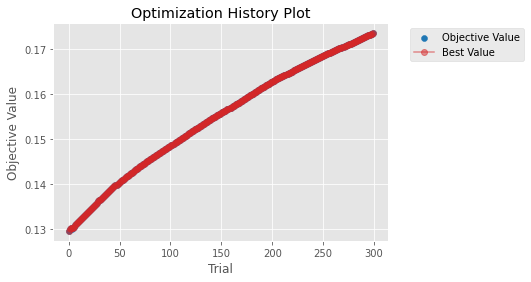

In [91]:
optuna.visualization.matplotlib.plot_optimization_history(study_lgbm175)

In [92]:
optuna.visualization.plot_param_importances(study_lgbm175)

In [95]:
optuna.visualization.plot_slice(study_lgbm175)

<br>
<br>


<font size='4' style="color:darkorchid"><b> Optimización de LightGBM PCA 100  </b> </font>

<a name="Optimizacion100"></a>

[[ Back to Top ]](#content)

Elegí evaluar la optimización de parámetros para el PCA 100 para ver si existe una gran diferencia con PCA 175.

In [80]:

#creamos una lista para almacenar todos los resultados de recall de cada fold
recall_results = [] 

# Objective function for the Light GBM Model
# ==============================================================================
def objective_lgbm(trial):
    # hyperparameter setting
    lgbm100__max_depth = trial.suggest_int ('lgbm100__max_depth', 3, 21)
    lgbm100__n_estimators = trial.suggest_int('lgbm100__n_estimators', 300, 3000, 10)
        
    #splitting the dataset
    for train_index, test_index in skf.split(X,y):
        X_train=pca100.fit_transform(X.iloc[train_index])
        X_test=pca100.transform(X.iloc[test_index])
        y_train=y.iloc[train_index]
        y_test=y.iloc[test_index]
        
             
    
    #model training
    model = LGBMClassifier(max_depth= lgbm100__max_depth, n_estimators= lgbm100__n_estimators)  
    model.fit(X_train, y_train)
    
    #predictions
    y_pred = model.predict(X_test)
    
    
    #evaluation metric
    recall = recall_score(y_test, y_pred)

    #agregamos los resultados de recall luego de cada fold a la lista de resultados
    recall_results.append(recall)
    
    return gmean(recall_results)

In [81]:
study_lgbm100 = optuna.create_study(direction= 'maximize')

study_lgbm100.optimize(objective_lgbm, n_trials= 300)

[I 2022-11-19 16:44:25,747] A new study created in memory with name: no-name-eac5c5d9-6e87-4a6d-9fd0-1f3de1cb6b3f
[I 2022-11-19 16:46:11,871] Trial 0 finished with value: 0.09800995024875624 and parameters: {'lgbm100__max_depth': 20, 'lgbm100__n_estimators': 2110}. Best is trial 0 with value: 0.09800995024875624.
[I 2022-11-19 16:47:23,299] Trial 1 finished with value: 0.1112894289526593 and parameters: {'lgbm100__max_depth': 9, 'lgbm100__n_estimators': 610}. Best is trial 1 with value: 0.1112894289526593.
[I 2022-11-19 16:48:59,061] Trial 2 finished with value: 0.12300031901326246 and parameters: {'lgbm100__max_depth': 4, 'lgbm100__n_estimators': 2100}. Best is trial 2 with value: 0.12300031901326246.
[I 2022-11-19 16:50:31,552] Trial 3 finished with value: 0.12209095039701708 and parameters: {'lgbm100__max_depth': 14, 'lgbm100__n_estimators': 2170}. Best is trial 2 with value: 0.12300031901326246.
[I 2022-11-19 16:52:10,545] Trial 4 finished with value: 0.11977565118808586 and parame

[I 2022-11-19 17:37:46,283] Trial 38 finished with value: 0.11918862142198652 and parameters: {'lgbm100__max_depth': 16, 'lgbm100__n_estimators': 1970}. Best is trial 2 with value: 0.12300031901326246.
[I 2022-11-19 17:39:10,147] Trial 39 finished with value: 0.1191564988365496 and parameters: {'lgbm100__max_depth': 11, 'lgbm100__n_estimators': 1750}. Best is trial 2 with value: 0.12300031901326246.
[I 2022-11-19 17:40:27,910] Trial 40 finished with value: 0.11945085099499649 and parameters: {'lgbm100__max_depth': 9, 'lgbm100__n_estimators': 1500}. Best is trial 2 with value: 0.12300031901326246.
[I 2022-11-19 17:41:40,321] Trial 41 finished with value: 0.11949673036714714 and parameters: {'lgbm100__max_depth': 16, 'lgbm100__n_estimators': 1160}. Best is trial 2 with value: 0.12300031901326246.
[I 2022-11-19 17:42:46,724] Trial 42 finished with value: 0.11977023490786383 and parameters: {'lgbm100__max_depth': 18, 'lgbm100__n_estimators': 870}. Best is trial 2 with value: 0.123000319013

[I 2022-11-19 18:27:36,933] Trial 77 finished with value: 0.12052944959661348 and parameters: {'lgbm100__max_depth': 6, 'lgbm100__n_estimators': 680}. Best is trial 2 with value: 0.12300031901326246.
[I 2022-11-19 18:28:41,980] Trial 78 finished with value: 0.12072297409189743 and parameters: {'lgbm100__max_depth': 6, 'lgbm100__n_estimators': 740}. Best is trial 2 with value: 0.12300031901326246.
[I 2022-11-19 18:29:46,776] Trial 79 finished with value: 0.1208729958201698 and parameters: {'lgbm100__max_depth': 6, 'lgbm100__n_estimators': 750}. Best is trial 2 with value: 0.12300031901326246.
[I 2022-11-19 18:30:44,975] Trial 80 finished with value: 0.1209799564939275 and parameters: {'lgbm100__max_depth': 6, 'lgbm100__n_estimators': 430}. Best is trial 2 with value: 0.12300031901326246.
[I 2022-11-19 18:31:42,839] Trial 81 finished with value: 0.12097892645460967 and parameters: {'lgbm100__max_depth': 6, 'lgbm100__n_estimators': 390}. Best is trial 2 with value: 0.12300031901326246.
[I

[I 2022-11-19 19:06:18,576] Trial 116 finished with value: 0.12203154884105603 and parameters: {'lgbm100__max_depth': 3, 'lgbm100__n_estimators': 790}. Best is trial 2 with value: 0.12300031901326246.
[I 2022-11-19 19:07:18,620] Trial 117 finished with value: 0.1220635864911101 and parameters: {'lgbm100__max_depth': 3, 'lgbm100__n_estimators': 830}. Best is trial 2 with value: 0.12300031901326246.
[I 2022-11-19 19:08:16,665] Trial 118 finished with value: 0.12213096332805064 and parameters: {'lgbm100__max_depth': 3, 'lgbm100__n_estimators': 820}. Best is trial 2 with value: 0.12300031901326246.
[I 2022-11-19 19:09:14,956] Trial 119 finished with value: 0.12218158786444606 and parameters: {'lgbm100__max_depth': 3, 'lgbm100__n_estimators': 800}. Best is trial 2 with value: 0.12300031901326246.
[I 2022-11-19 19:10:14,201] Trial 120 finished with value: 0.12230684071851368 and parameters: {'lgbm100__max_depth': 3, 'lgbm100__n_estimators': 900}. Best is trial 2 with value: 0.123000319013262

[I 2022-11-19 19:49:41,776] Trial 155 finished with value: 0.1273807679313488 and parameters: {'lgbm100__max_depth': 5, 'lgbm100__n_estimators': 1070}. Best is trial 155 with value: 0.1273807679313488.
[I 2022-11-19 19:50:55,662] Trial 156 finished with value: 0.12749023024019682 and parameters: {'lgbm100__max_depth': 5, 'lgbm100__n_estimators': 1090}. Best is trial 156 with value: 0.12749023024019682.
[I 2022-11-19 19:52:09,135] Trial 157 finished with value: 0.1275928679312711 and parameters: {'lgbm100__max_depth': 5, 'lgbm100__n_estimators': 1060}. Best is trial 157 with value: 0.1275928679312711.
[I 2022-11-19 19:53:31,296] Trial 158 finished with value: 0.12773728887532718 and parameters: {'lgbm100__max_depth': 5, 'lgbm100__n_estimators': 1080}. Best is trial 158 with value: 0.12773728887532718.
[I 2022-11-19 19:54:50,563] Trial 159 finished with value: 0.12784548769772386 and parameters: {'lgbm100__max_depth': 5, 'lgbm100__n_estimators': 1210}. Best is trial 159 with value: 0.127

[I 2022-11-19 20:39:54,463] Trial 193 finished with value: 0.12966491290424279 and parameters: {'lgbm100__max_depth': 7, 'lgbm100__n_estimators': 1320}. Best is trial 193 with value: 0.12966491290424279.
[I 2022-11-19 20:41:09,443] Trial 194 finished with value: 0.1296734649871481 and parameters: {'lgbm100__max_depth': 7, 'lgbm100__n_estimators': 1340}. Best is trial 194 with value: 0.1296734649871481.
[I 2022-11-19 20:42:26,089] Trial 195 finished with value: 0.12966927968273828 and parameters: {'lgbm100__max_depth': 7, 'lgbm100__n_estimators': 1300}. Best is trial 194 with value: 0.1296734649871481.
[I 2022-11-19 20:43:42,025] Trial 196 finished with value: 0.12961499910857113 and parameters: {'lgbm100__max_depth': 7, 'lgbm100__n_estimators': 1340}. Best is trial 194 with value: 0.1296734649871481.
[I 2022-11-19 20:44:57,184] Trial 197 finished with value: 0.12967378822207498 and parameters: {'lgbm100__max_depth': 7, 'lgbm100__n_estimators': 1330}. Best is trial 197 with value: 0.129

[I 2022-11-19 21:29:21,925] Trial 231 finished with value: 0.1290773478569601 and parameters: {'lgbm100__max_depth': 7, 'lgbm100__n_estimators': 1350}. Best is trial 197 with value: 0.12967378822207498.
[I 2022-11-19 21:30:39,031] Trial 232 finished with value: 0.12911760922645873 and parameters: {'lgbm100__max_depth': 7, 'lgbm100__n_estimators': 1290}. Best is trial 197 with value: 0.12967378822207498.
[I 2022-11-19 21:31:55,168] Trial 233 finished with value: 0.12911861525547133 and parameters: {'lgbm100__max_depth': 8, 'lgbm100__n_estimators': 1390}. Best is trial 197 with value: 0.12967378822207498.
[I 2022-11-19 21:33:07,725] Trial 234 finished with value: 0.1291362649315948 and parameters: {'lgbm100__max_depth': 8, 'lgbm100__n_estimators': 1150}. Best is trial 197 with value: 0.12967378822207498.
[I 2022-11-19 21:34:23,187] Trial 235 finished with value: 0.12913507490014753 and parameters: {'lgbm100__max_depth': 7, 'lgbm100__n_estimators': 1280}. Best is trial 197 with value: 0.1

[I 2022-11-19 22:17:24,980] Trial 269 finished with value: 0.12925712879756368 and parameters: {'lgbm100__max_depth': 8, 'lgbm100__n_estimators': 1350}. Best is trial 197 with value: 0.12967378822207498.
[I 2022-11-19 22:18:38,790] Trial 270 finished with value: 0.12928075658731197 and parameters: {'lgbm100__max_depth': 7, 'lgbm100__n_estimators': 1270}. Best is trial 197 with value: 0.12967378822207498.
[I 2022-11-19 22:19:53,884] Trial 271 finished with value: 0.1292717939277979 and parameters: {'lgbm100__max_depth': 8, 'lgbm100__n_estimators': 1410}. Best is trial 197 with value: 0.12967378822207498.
[I 2022-11-19 22:21:12,682] Trial 272 finished with value: 0.12929865459434467 and parameters: {'lgbm100__max_depth': 6, 'lgbm100__n_estimators': 1560}. Best is trial 197 with value: 0.12967378822207498.
[I 2022-11-19 22:22:33,652] Trial 273 finished with value: 0.1293024698581387 and parameters: {'lgbm100__max_depth': 7, 'lgbm100__n_estimators': 1160}. Best is trial 197 with value: 0.1

In [82]:
print('Best Value: {}'.format(study_lgbm100.best_value))
print('Best Parameters: {}'.format(study_lgbm100.best_params))

Best Value: 0.13034733507671567
Best Parameters: {'lgbm100__max_depth': 3, 'lgbm100__n_estimators': 2930}


In [83]:
joblib.dump(study_lgbm100, "study_lgbm100.pkl")

['study_lgbm100.pkl']

C:\Users\Madelaine\AppData\Local\Temp\ipykernel_16900\1294449387.py:1: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

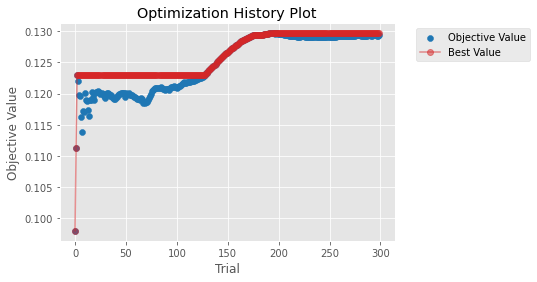

In [84]:
optuna.visualization.matplotlib.plot_optimization_history(study_lgbm100)

In [85]:
optuna.visualization.plot_param_importances(study_lgbm100)

In [78]:
optuna.visualization.plot_slice(study_lgbm100)

<br>

<font size='4' style="color:darkorchid"><b> LightGBM optimizado  </b> </font>

<a name="Optimizado"></a>

[[ Back to Top ]](#content)

LightGBM optimizado con los parámetros de lgbm PCA 175

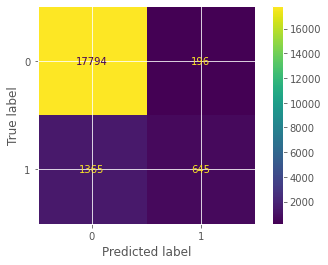

Precision's geometric mean is  0.7562584931964201
Recall's geometric mean is  0.3032779151315591
F1 geometric mean is  0.4328797185029462
El tiempo del modelo fue de  371.4043061733246 segundos


In [94]:
#Calling the model
lgbm_Opt = LGBMClassifier(n_estimators= 510, max_depth=7)

#lista para almacenar las métricas de cada fold
model_metrics=[]

#inicio el contador de tiempo para calcular el costo del modelo
inicio = time.time()

#Split between training and testing
for train_index, test_index in skf.split(X, y):
        
    X_train=X.iloc[train_index]
    X_test=X.iloc[test_index]
    y_train=y.iloc[train_index]
    y_test=y.iloc[test_index]
    
    #fit the model
    lgbm_Opt.fit(X_train, y_train)
    
    #make predictions
    y_pred=lgbm_Opt.predict(X_test)
    
    #calculate metrics
    cm=confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1= f1_score(y_test, y_pred)

    #store each fold's metrics
    results = [precision, recall, f1]
    model_metrics.append(results)
    
#display the first fold's confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()
plt.show()

#finalizamos el contador de tiempo del modelo
fin = time.time()

#store and print the metric's gmean after the 10 folds
results_gmean= gmean(model_metrics)
print("Precision's geometric mean is " , results_gmean[0])
print("Recall's geometric mean is ", results_gmean[1])
print("F1 geometric mean is ", results_gmean[2])

#add these to the general lists
models.append("Light GBM Optimized")
metrics.append(results_gmean)
tiempo.append(fin-inicio)

print("El tiempo del modelo fue de ", fin-inicio, "segundos")

<br>
<br>

<font size='4' style="color:darkorchid"><b> Resumen de todos los modelos y conclusión </b> </font>

<a name="Resumen_final"></a>

[[ Back to Top ]](#content)

In [98]:
models

['Light GBM',
 'Light GBM 175',
 'Light GBM 150',
 'Light GBM 125',
 'Light GBM 100',
 'Light GBM Optimized']

In [99]:
#Creo un dataframe para visualizar como tabla las 3 métricas calculadas para todos los modelos evaluados
#Los nombres de los modelos fueron almacenados en la lista modelos cuando se fueron corriendo

columnas = ["PRECISION", "RECALL", "F1"]
resumen_todo = pd.DataFrame(metrics, columns=columnas, index=models)
resumen_todo

,PRECISION,RECALL,F1
Light GBM,0.873149,0.094699,0.170858
Light GBM 175,0.275031,0.005778,0.011315
Light GBM 150,0.310674,0.007474,0.014591
Light GBM 125,0.229340,0.003824,0.007519
Light GBM 100,0.236974,0.004316,0.008477
Light GBM Optimized,0.756258,0.303278,0.432880


In [100]:
#Agrego la columna tiempo para incluir el tiempo de ejecución de los 10 folds para todos los modelos

resumen_todo['TIEMPO (s)'] = tiempo
resumen_todo

,PRECISION,RECALL,F1,TIEMPO (s)
Light GBM,0.873149,0.094699,0.170858,110.110684
Light GBM 175,0.275031,0.005778,0.011315,106.986195
Light GBM 150,0.310674,0.007474,0.014591,146.930326
Light GBM 125,0.229340,0.003824,0.007519,129.096900
Light GBM 100,0.236974,0.004316,0.008477,119.717989
Light GBM Optimized,0.756258,0.303278,0.432880,371.404306


In [104]:
#guardo el dataframe con los parámetros, tiempo de ejecución y modelos en un archivo pkl

resumen.to_pickle('df_resumen_LGBM_con_optimizado.pkl')

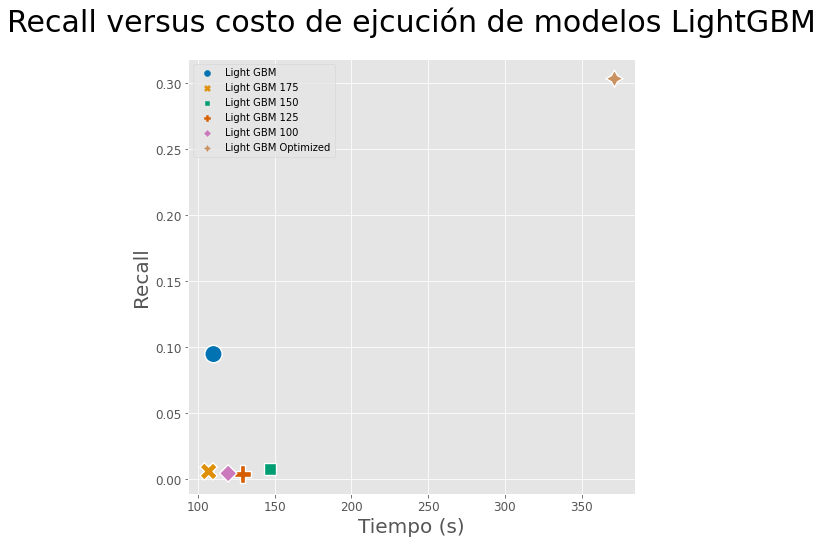

In [103]:
#Creo la misma información en un gráfico. Recall será la métrica utilizada 

plt.figure(figsize = (8, 8))
sns.scatterplot(data = resumen_todo, x = resumen_todo['TIEMPO (s)'],y = resumen_todo['RECALL'], 
                hue = resumen_todo.index, style = resumen_todo.index, palette = 'colorblind', s = 300) 
plt.xlabel('Tiempo (s)', y = -0.8, fontsize = 20)
plt.ylabel('Recall', x = -1, fontsize = 20)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.title('Recall versus costo de ejcución de modelos LightGBM', y = 1.05, fontsize = 30)
plt.show()

La optmización de los parámetros del modelo LightGBM en el modelo con PCA 175 y luego utilizados con el dataset completo triplicó el Recall del modelo pero su costo fue 3.4 veces mayor. Si bien el tiempo de ejecución es abreviado, es un valor a considerar. 

Dado que la búsqueda de optimización de este modelo fue hecha para luego implementar estos parámetros en modelos más complejos de Boost, veremos solo allí si realmente hace una diferencia en el recall el uso de estos parámetros. 